<a href="https://www.kaggle.com/code/vikkach/monet-cyclegan?scriptVersionId=234539172" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Concatenate, ZeroPadding2D
import os
from glob import glob
from PIL import Image
import shutil

from kaggle_datasets import KaggleDatasets

2025-04-17 22:01:57.291198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744927317.492831      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744927317.550905      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU!")
except:
    strategy = tf.distribute.get_strategy()  # Default to GPU/CPU
    print("Running on CPU/GPU")

AUTOTUNE = tf.data.experimental.AUTOTUNE

Running on CPU/GPU


In [4]:
class Config():
    seed = 42
    monet_path = '/monet_tfrec/*.tfrec'
    photo_path = '/photo_tfrec/*.tfrec'
    image_size = [256, 256]
    monet_filenames = []
    photo_filenames = []
    identity_weight = 2.0
    batch_size = 1
    epochs = 40

In [5]:
tf.random.set_seed(Config.seed)
np.random.seed(Config.seed)

<div style="background-color: #2C3E50; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Use GANs to create art
</div>

<div style="background-color: #9B59B6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Problem Statement
</div>

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

The goal is to build a GAN that generates 7,000 to 10,000 Monet-style images.

## Dataset

* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

<div style="background-color: #9B59B6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    EDA
</div>

Let's use [Amy Jang's notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial) that goes over the basics of loading data from TFRecords, using TPUs, and building a CycleGAN.

In [6]:
gcs_path = KaggleDatasets().get_gcs_path()

In [7]:
Config.monet_filenames = tf.io.gfile.glob(str(gcs_path + Config.monet_path))
print('Monet TFRecord Files:', len(Config.monet_filenames))

Config.photo_filenames = tf.io.gfile.glob(str(gcs_path + Config.photo_path))
print('Photo TFRecord Files:', len(Config.photo_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [8]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*Config.image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [9]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [10]:
monet_ds = load_dataset(Config.monet_filenames, labeled=True).batch(1)
photo_ds = load_dataset(Config.photo_filenames, labeled=True).batch(1)

I0000 00:00:1744927331.703555      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

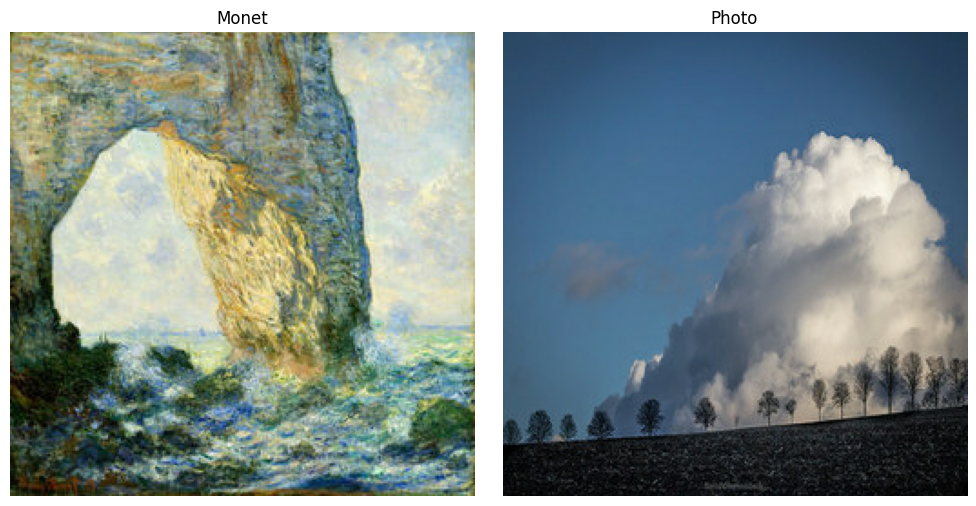

In [12]:
# Plot 1 image from each set
plt.figure(figsize=(10, 5))

# Monet image
ax = plt.subplot(1, 2, 1)
plt.imshow((example_monet[0].numpy() * 0.5 + 0.5))  # Unnormalize if in [-1, 1]
plt.title("Monet")
plt.axis("off")

# Photo image
ax = plt.subplot(1, 2, 2)
plt.imshow((example_photo[0].numpy() * 0.5 + 0.5))  # Unnormalize if in [-1, 1]
plt.title("Photo")
plt.axis("off")

plt.tight_layout()
plt.show()

<div style="background-color: #9B59B6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    CycleGAN Model
</div>

The goal of this CycleGAN model is to perform unpaired image-to-image translation between two domains:

* Photos (real-world images)
* Monet paintings (art-style domain)
 
The model learns to translate photos to Monet-style images without needing 1-to-1 paired examples.

## Why CycleGAN?

* No need for paired images
* Well-suited for style transfer tasks like
* Proven success in artistic domain generation tasks

## How It Works

CycleGAN uses:

Two generators:

* G: Photo → Monet
* F: Monet → Photo

Two discriminators:

* D_Y: distinguishes real Monet paintings from generated ones
* D_X: distinguishes real photos from generated ones

## Model Architecture
**Generator (G & F)**

* Based on U-Net

* Consists of:
1. Downsampling (Conv + BatchNorm + LeakyReLU)
2. Residual blocks
3. Upsampling (Transposed Conv)


**Discriminator (D_X & D_Y)**

* PatchGAN architecture
* Judges authenticity over image patches, not the full image
* Helps the model focus on local texture and style

In [13]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential([
        Conv2D(filters, size, strides=2, padding='same',
               kernel_initializer=initializer, use_bias=False),
    ])
    if apply_batchnorm:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential([
        Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False),
        BatchNormalization()
    ])
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

In [14]:
def Generator():
    inputs = Input(shape=[*Config.image_size, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
    ]
    up_stack = [
        upsample(128, 4),  # (bs, 64, 64, 128)
        upsample(64, 4),   # (bs, 128, 128, 64)
    ]
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                            kernel_initializer=tf.random_normal_initializer(0., 0.02),
                            activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs=inputs, outputs=x)

In [15]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=[*Config.image_size, 3], name='input_image')
    x = downsample(64, 4, False)(inp)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = ZeroPadding2D()(x)
    x = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = ZeroPadding2D()(x)
    x = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return Model(inputs=inp, outputs=x)


In [16]:
generator_g = Generator()  # Monet → Photo
generator_f = Generator()  # Photo → Monet

discriminator_x = Discriminator()  # Discriminator for Monet
discriminator_y = Discriminator()  # Discriminator for Photo

In [17]:
generator_f.summary()
discriminator_x.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 128, 128, 64)   │          3,072 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 64, 64, 128)    │        131,584 │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 32, 32, 256)    │        525,312 │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 64, 64, 128)    │        524,800 │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 64, 64, 256)    │              0 │ sequential_8[0][0],    │
│ (Concatenate)             │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (None, 128, 128, 64)   │        262,400 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 128, 128, 128)  │              0 │ sequential_9[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 256, 256, 3)    │          6,147 │ concatenate_3[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,453,315 (5.54 MB)

 Trainable params: 1,452,163 (5.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (None, 128, 128, 64)        │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 64, 64, 128)         │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 32, 32, 256)         │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 31, 31, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 31, 31, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 30, 30, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Let's create loss functions for CycleGAN. The model uses a combination of adversarial, cycle consistency, and identity losses to guide both the generators and discriminators.

* discriminator_loss - train discriminator to separate real/fake
* generator_loss - train generator to fool discriminator
* cycle_loss - ensure round-trip image consistency
* identity_loss - preserve input when already in target domain

In [18]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * 10.0

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * 5.0

This function defines a single training step for the CycleGAN model. It performs forward and backward passes for both generators and discriminators, and updates their weights using the computed gradients.

The function is wrapped in @tf.function to compile it into a TensorFlow graph for optimized execution.

In [19]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) * Config.identity_weight
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    generator_g_grad = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_grad = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_grad = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_grad = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_grad, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_grad, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_grad, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_grad, discriminator_y.trainable_variables))


Let's train our model.

In [20]:
def visualize_epoch_result(epoch):
    # Visualize intermediate epochs
    if (epoch + 1) % 5 == 0:
        os.makedirs("cycle_outputs", exist_ok=True)
        
        sample_photo = next(iter(photo_ds))
        prediction = generator_g(sample_photo)
    
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow((sample_photo[0] * 0.5 + 0.5).numpy())
        plt.title("Input")
        plt.axis('off')
    
        plt.subplot(1, 2, 2)
        plt.imshow((prediction[0] * 0.5 + 0.5).numpy())
        plt.title(f"Epoch {epoch+1}")
        plt.axis('off')
    
        plt.tight_layout()
        plt.savefig(f"cycle_outputs/epoch_{epoch+1}.png")
        plt.show()

In [21]:
def recalc_losses():
    sample_photo = next(iter(photo_ds))
    sample_monet = next(iter(monet_ds))

    fake_y = generator_g(sample_photo, training=False)
    cycled_x = generator_f(fake_y, training=False)
    fake_x = generator_f(sample_monet, training=False)
    cycled_y = generator_g(fake_x, training=False)
    same_x = generator_f(sample_photo, training=False)
    same_y = generator_g(sample_monet, training=False)

    disc_real_x = discriminator_x(sample_photo, training=False)
    disc_fake_x = discriminator_x(fake_x, training=False)
    disc_real_y = discriminator_y(sample_monet, training=False)
    disc_fake_y = discriminator_y(fake_y, training=False)

    # Calculate losses for visualization
    g_loss = generator_loss(disc_fake_y)
    f_loss = generator_loss(disc_fake_x)
    cyc_loss = cycle_loss(sample_photo, cycled_x) + cycle_loss(sample_monet, cycled_y)
    id_loss = identity_loss(sample_monet, same_y) + identity_loss(sample_photo, same_x)
    dx_loss = discriminator_loss(disc_real_x, disc_fake_x)
    dy_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Append losses
    gen_g_losses.append(g_loss.numpy())
    gen_f_losses.append(f_loss.numpy())
    disc_x_losses.append(dx_loss.numpy())
    disc_y_losses.append(dy_loss.numpy())
    cycle_losses.append(cyc_loss.numpy())
    identity_losses.append(id_loss.numpy())

In [22]:
initial_lr = 2e-4
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[20],  # after 20 epochs
    values=[initial_lr, initial_lr * 0.5]  # decay to half
)

# apply clipnorm=1.0 to make backpropagation more stable
generator_g_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5, clipnorm=1.0)
generator_f_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)

I0000 00:00:1744927362.428047      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/40 done.
Epoch 2/40 done.
Epoch 3/40 done.
Epoch 4/40 done.


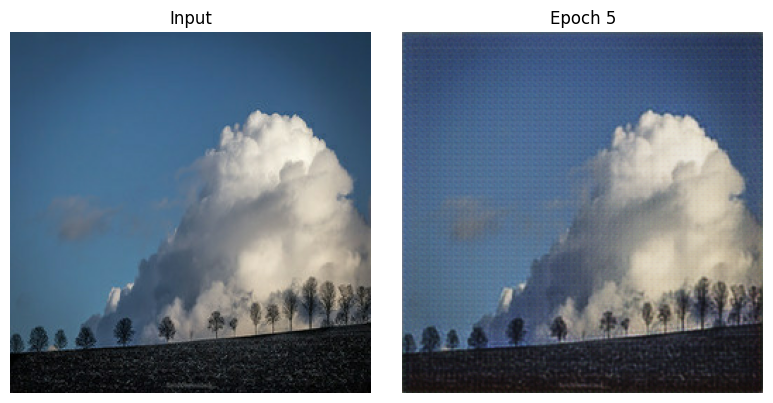

Epoch 5/40 done.
Epoch 6/40 done.
Epoch 7/40 done.
Epoch 8/40 done.
Epoch 9/40 done.


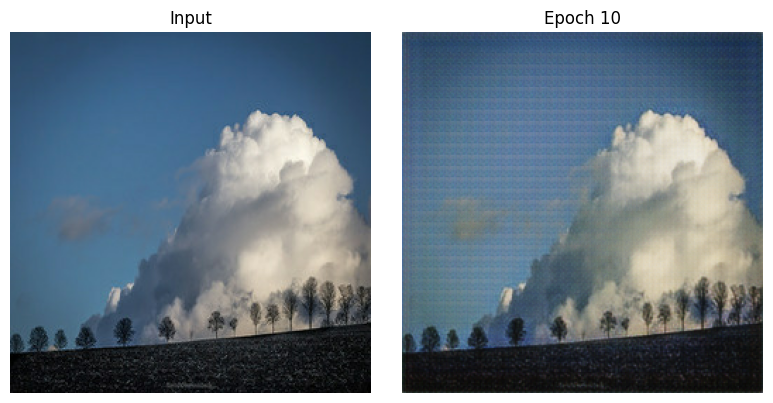

Epoch 10/40 done.
Epoch 11/40 done.
Epoch 12/40 done.
Epoch 13/40 done.
Epoch 14/40 done.


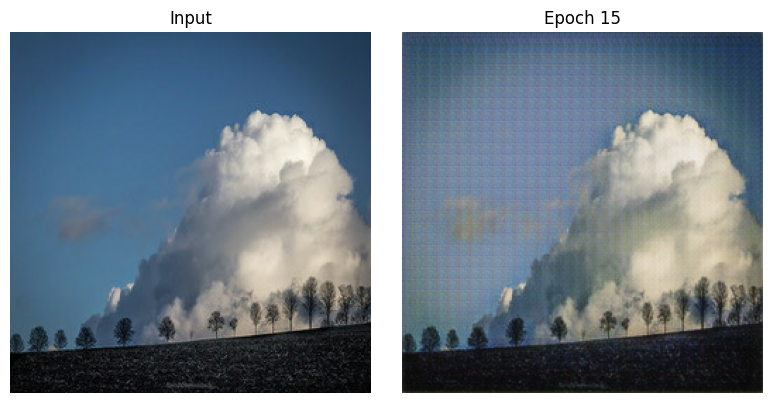

Epoch 15/40 done.
Epoch 16/40 done.
Epoch 17/40 done.
Epoch 18/40 done.
Epoch 19/40 done.


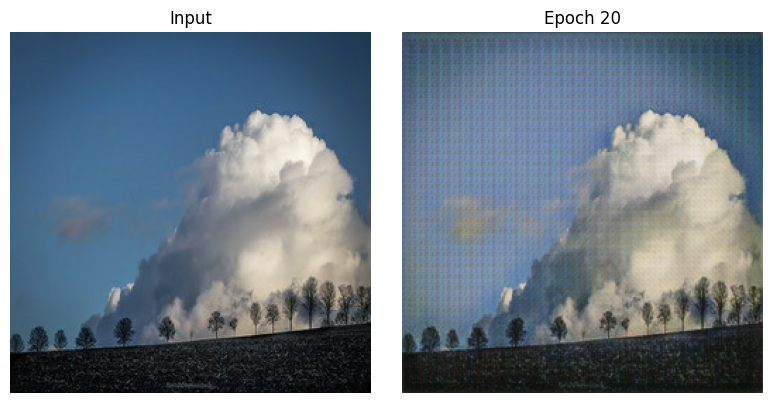

Epoch 20/40 done.
Epoch 21/40 done.
Epoch 22/40 done.
Epoch 23/40 done.
Epoch 24/40 done.


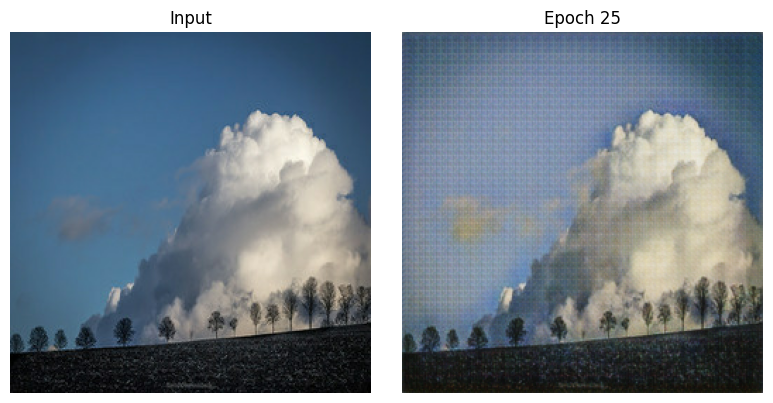

Epoch 25/40 done.
Epoch 26/40 done.
Epoch 27/40 done.
Epoch 28/40 done.
Epoch 29/40 done.


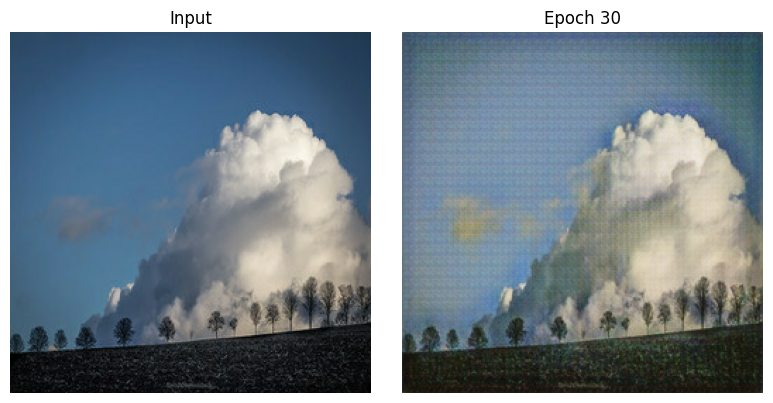

Epoch 30/40 done.
Epoch 31/40 done.
Epoch 32/40 done.
Epoch 33/40 done.
Epoch 34/40 done.


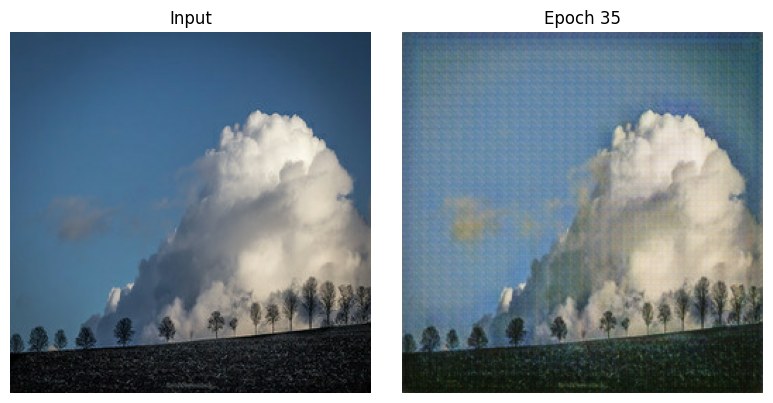

Epoch 35/40 done.
Epoch 36/40 done.
Epoch 37/40 done.
Epoch 38/40 done.
Epoch 39/40 done.


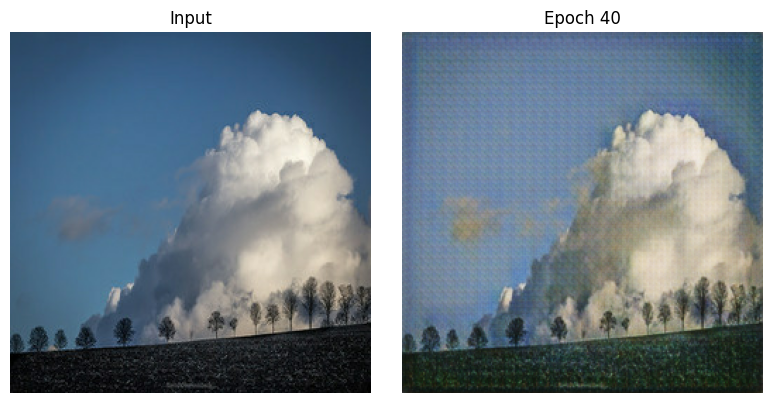

Epoch 40/40 done.


In [23]:
gen_g_losses = []
gen_f_losses = []
disc_x_losses = []
disc_y_losses = []
cycle_losses = []
identity_losses = []

for epoch in range(Config.epochs):
    for image_x, image_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(image_x, image_y)
        
    recalc_losses()
    visualize_epoch_result(epoch)
    
    print(f"Epoch {epoch+1}/{Config.epochs} done.")

Plot loss curves

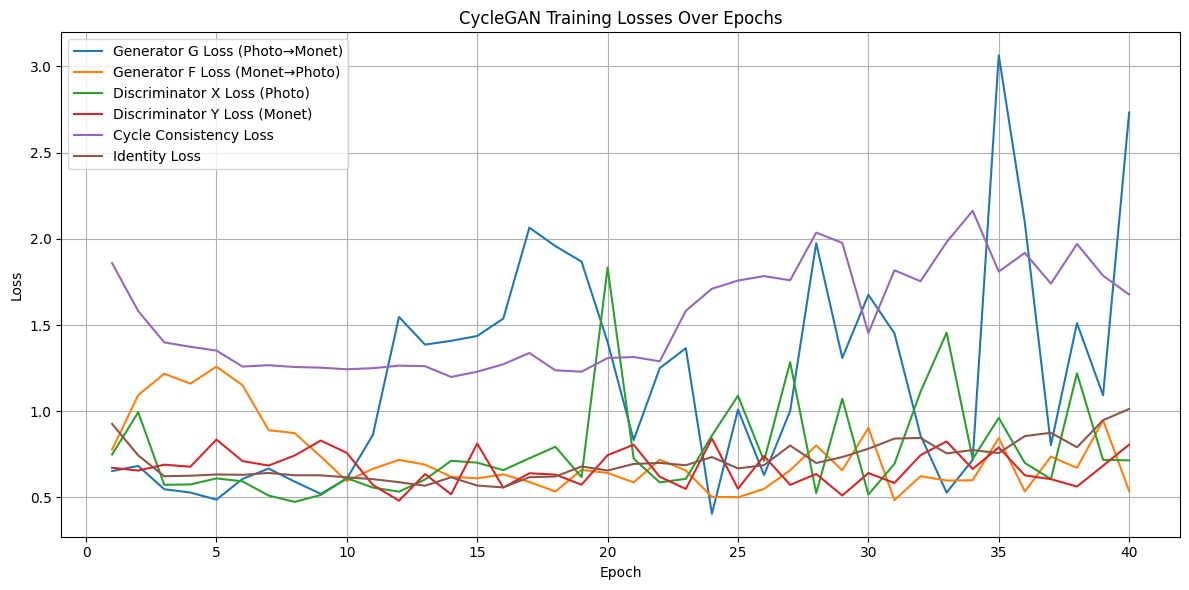

In [24]:
epochs = range(1, len(gen_g_losses) + 1)

plt.figure(figsize=(12, 6))

plt.plot(epochs, gen_g_losses, label='Generator G Loss (Photo→Monet)')
plt.plot(epochs, gen_f_losses, label='Generator F Loss (Monet→Photo)')
plt.plot(epochs, disc_x_losses, label='Discriminator X Loss (Photo)')
plt.plot(epochs, disc_y_losses, label='Discriminator Y Loss (Monet)')
plt.plot(epochs, cycle_losses, label='Cycle Consistency Loss')
plt.plot(epochs, identity_losses, label='Identity Loss')

plt.title("CycleGAN Training Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Cycle Consistency Loss:

* Starts high and steadily decreases, indicating that the model is learning to preserve the structure of the input images when translating and cycling back.
* A smooth decline here is a good sign — the generators are becoming more consistent.

Generator Losses:

* G (Photo → Monet) (Blue): Fairly stable and relatively low, suggesting the Monet generator is learning steadily.
* F (Monet → Photo) (Orange): Slightly noisier and higher, with a spike around epoch 5 and some recovery after — this may suggest a temporary imbalance, or that the Monet → Photo translation is more difficult.

Discriminator Losses:

* Discriminator X (Photo) and Y (Monet) are moderate and stable, indicating that the discriminators are not overpowering the generators (no collapse).
* Slight fluctuations are normal as generators and discriminators compete.

Identity Loss:

* Gradually decreasing and staying under control, suggesting the model is learning to preserve features when translating images already in the target domain.
* No sharp spikes — a good regularization signal.

Visualize some image examples

In [25]:
def generate_images(model, test_input):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(12, 6))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Translated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5).numpy())
        plt.axis('off')
    plt.show()

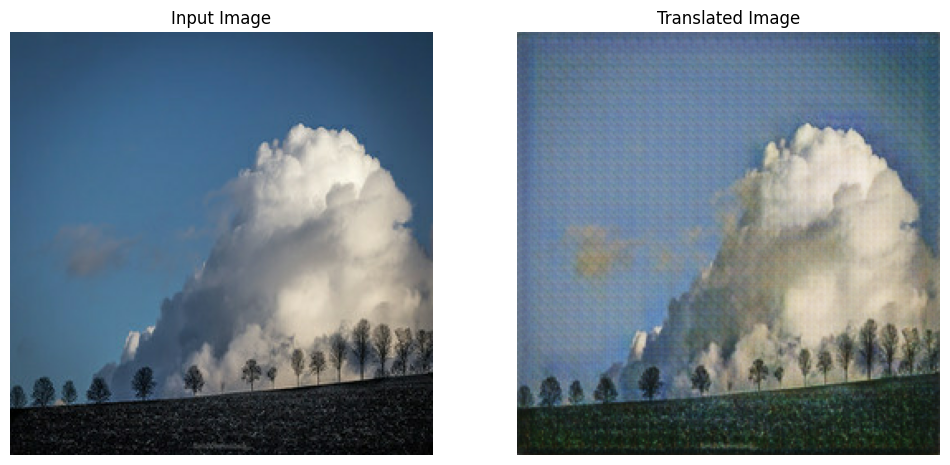

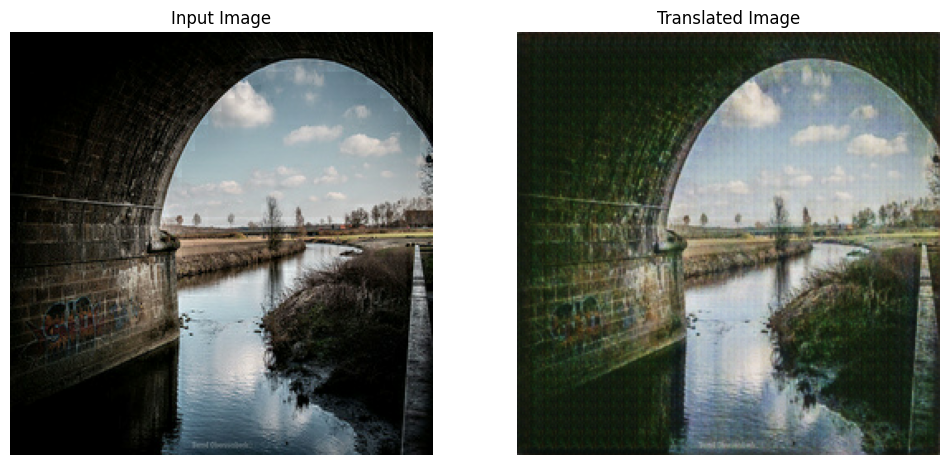

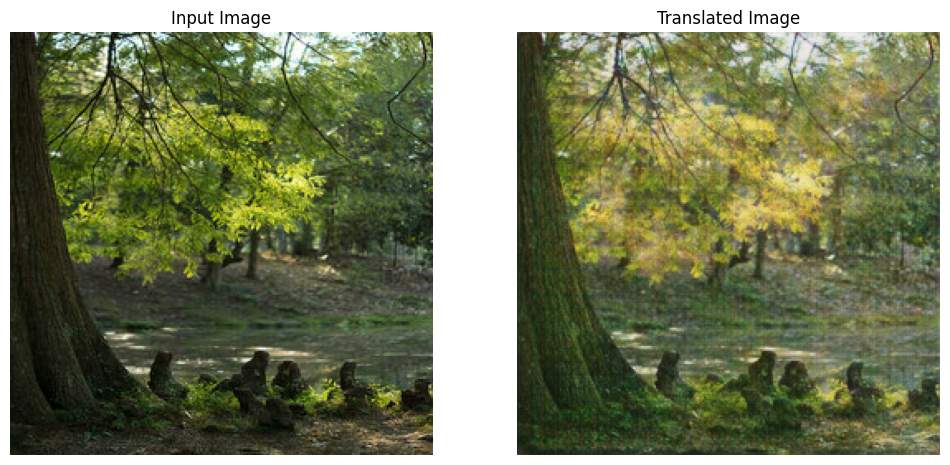

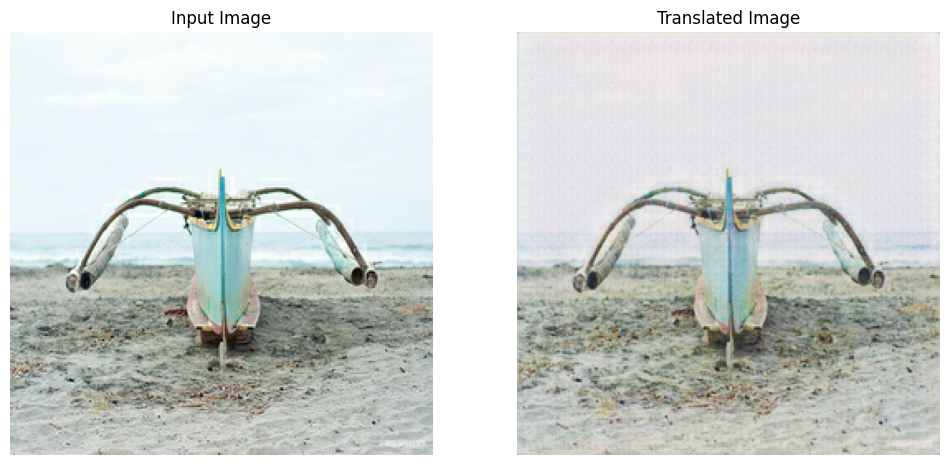

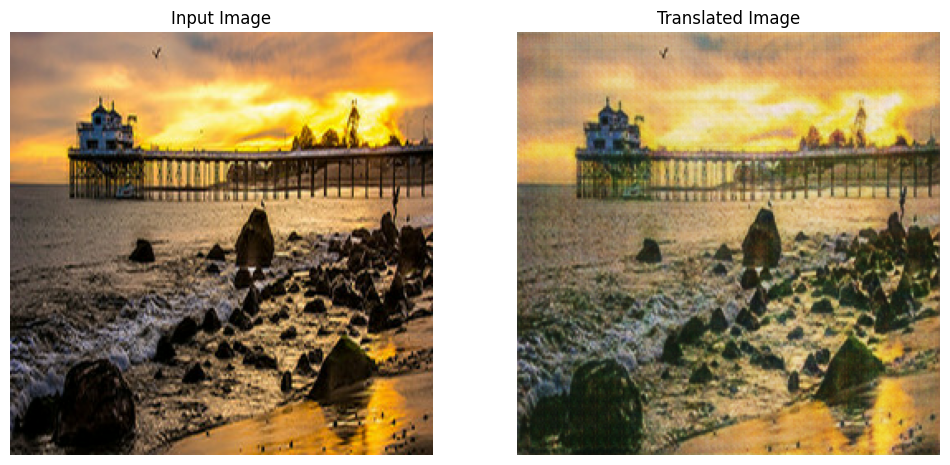

In [26]:
for i, batch in enumerate(photo_ds):
    generate_images(generator_g, batch)
    if i == 4:
        break

<div style="background-color: #9B59B6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Conclusion
</div>

In this project was implemented and trained a CycleGAN model to translate real-world photos into Monet-style paintings using unpaired image data.

By leveraging a U-Net–based generator and a PatchGAN discriminator, the model was able to learn the underlying texture and brushstroke patterns of Monet's style while preserving the content and structure of the original photographs.

Key Takeaways:
* Cycle Consistency was essential for training without paired datasets, ensuring that images translated back and forth retained their identity.
* Adversarial Losses helped the generator learn to produce realistic images that could fool the discriminator.
* Identity Loss acted as a regularizer, improving color preservation and reducing over-stylization.
* Visualizing training losses and intermediate outputs provided valuable insight into model progress and stability.

The final model demonstrates a convincing ability to translate modern photos into impressionist artwork, with stylistic features resembling Monet’s paintings — including soft colors, blended textures, and painterly strokes.

Future Improvements:
* Switch to a ResNet-based generator for more stylized results.
* Apply style-guided augmentation or content masks for fine-grained control.
* Use perceptual loss for better high-level feature alignment.

<div style="background-color: #9B59B6; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Submission
</div>

In [27]:
! mkdir ../images

In [28]:
i = 1
for img in photo_ds:
    prediction = generator_g(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [29]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'